## Historical Emissions Descriptive Data Analysis
This notebook explores the ClimateWatch Global Historical emissions data and makes comparisons to global warming trends explored in other parts of this project.

Data Source: 
ClimateWatchData - Global Historical Emissions
Source: https://www.climatewatchdata.org/ghg-emissions?end_year=2018&start_year=1990
About ClimateWatch: https://www.climatewatchdata.org/about/description

In [1]:
import csv
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from splot.mapping import vba_choropleth

mpl.rcParams.update(mpl.rcParamsDefault)

#Read in file, set first column (countries) as the index
fileIn = pd.read_csv('./data_files/ghg-emissions-pik.csv', index_col=0)
ems = pd.DataFrame(fileIn)

#remove false values
ems = ems.replace(to_replace = "FALSE", value=0)

## Total Greenhouse Gas Emissions - historical view all GHG emissions globally

In [2]:
#add column for total emissions (by country) 1990 - 2018
ems['Country_Total'] = ems.sum(numeric_only=True, axis=1)
ems = ems.sort_values('Country_Total', axis=0)

#sum of each column
yT = pd.DataFrame(ems.sum())
yrTotals = yT.drop(labels=['Country_Total'], axis=0)

yrTotals.columns = ['total']
yrTotals.plot(title='Greenhouse Gas Emissions - Globally 1850-2018', xlabel='Year', ylabel='Global Emissions (MtCO2e)')

yrTotals

total
1850    929.98
1851    957.41
1852    987.86
1853   1021.53
1854   1082.67
...        ...
2014  46744.23
2015  46759.58
2016  47075.88
2017  47712.86
2018  48601.02

[169 rows x 1 columns]

## GHG Emissions Inflection Point

In [3]:
#Prepare data - decade by decade view
decTotals = yrTotals.reset_index()
decTotals.columns = ['year', 'total']

#group every 10 years
decTotals = decTotals.groupby(decTotals.index//10).sum()

#add decade as index
decs = list(range(1850,2018,10))
decTotals.insert(0, "decade", decs, True)

pctChgD = decTotals["total"].pct_change()
decTotals.insert(2, "% change", pctChgD, True)

In [4]:
#plots to show general trend shift
print(decTotals)
plt.plot(decs, decTotals["total"], marker='o')

    decade      total  % change
0     1850   10863.37       NaN
1     1860   14865.92  0.368445
2     1870   20382.41  0.371083
3     1880   28101.65  0.378721
4     1890   36454.30  0.297230
5     1900   48937.91  0.342445
6     1910   61559.43  0.257909
7     1920   70129.44  0.139215
8     1930   75544.55  0.077216
9     1940   95349.47  0.262162
10    1950  132036.75  0.384766
11    1960  188692.83  0.429093
12    1970  268492.30  0.422907
13    1980  299360.00  0.114967
14    1990  327673.93  0.094582
15    2000  385909.51  0.177724
16    2010  417690.73  0.082354


/Users/tiffany/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/tiffany/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


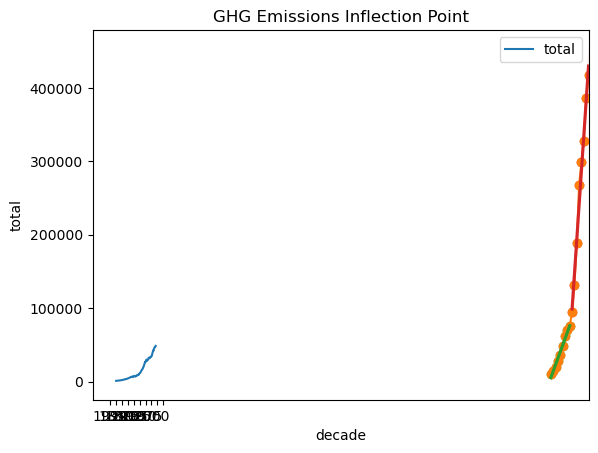

In [5]:
dec_1h = decTotals.iloc[:9,:]
dec_2h = decTotals.iloc[9:,:]

#make the break at 1960

slope, intercept, r_value, p_value, std_err = stats.linregress(dec_1h["decade"], dec_1h["total"])

ax1 = sns.regplot(dec_1h["decade"], dec_1h["total"], data = dec_1h, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax2 = sns.regplot(dec_2h["decade"], dec_2h["total"], data = dec_2h, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)}).set(title='GHG Emissions Inflection Point')

# ax1.legend() no regression line equations available in seaborn
# ax2.legend()

plt.show()

## Total Greenhouse Gases - Map View

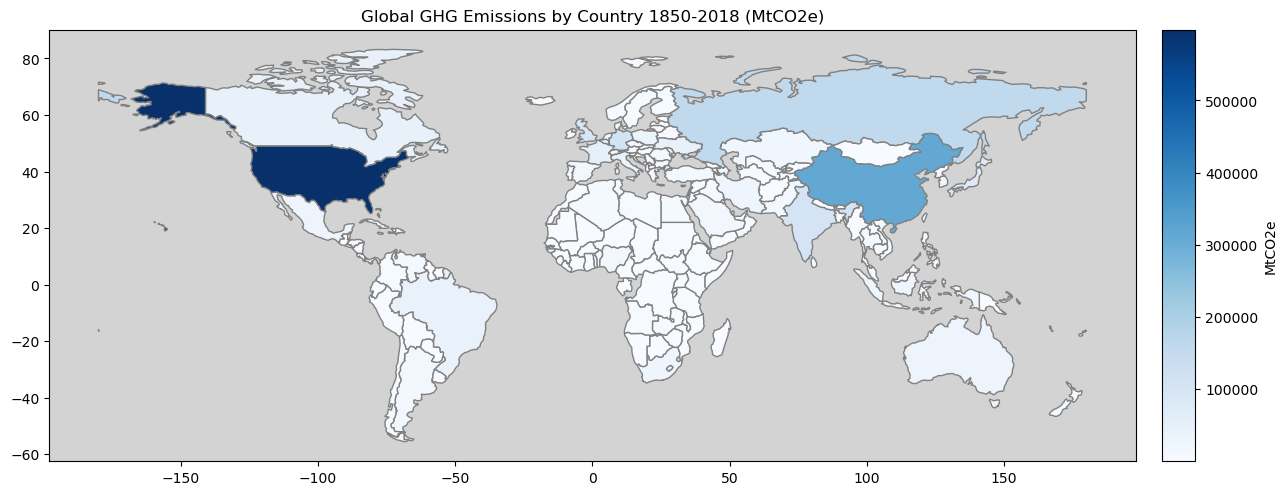

In [15]:
map_df = ems[["Country_Total"]]
map_df = map_df.reset_index()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.at[4,'name'] = "United States"
map_df['Country/Region'] = map_df['Country/Region'].replace(['Republic of Congo'], 'Dem. Rep. Congo')
map_df['Country/Region'] = map_df['Country/Region'].replace(['Antarctica'], 'N/A')
map_df['Country/Region'] = map_df['Country/Region'].replace(['Central African Republic'], 'Central African Rep.')
map_df['Country/Region'] = map_df['Country/Region'].replace(['Taiwan, Republic of China'], 'Taiwan')
map_df['Country/Region'] = map_df['Country/Region'].replace(['Czech Republic'], 'Czechia')
map_df['Country/Region'] = map_df['Country/Region'].replace(['South Sudan'], 'S. Sudan')
map_df['Country/Region'] = map_df['Country/Region'].replace(['Dominican Republic'], 'Dominican Rep.')

#world=world[(world.name !="Antarctica")]

match_world = []
mismatch_world = []
for x in list(map_df['Country/Region']):
    if x in list(world['name']):
        match_world.append(x)
    else: 
        mismatch_world.append(x)
        
world_df = pd.concat([world.set_index('name'),map_df.set_index('Country/Region')], axis=1, join='inner').reset_index()
world_df = world_df.rename(columns={"index":"country"})
#world = world[(world.Country_Total) & (world.index!="")] #only if specifying conditions for the map

#suggestions:
#drop antarctica 
#grey color as background 

fig_e,ax_e = plt.subplots(1,1)
divider = make_axes_locatable(ax_e)
cax = divider.append_axes("right", size="3%", pad=0.1)
world_df.plot(column='Country_Total', ax=ax_e, legend=True, legend_kwds={'label': "MtCO2e", "fmt": "{:.0f}"}, cax=cax, cmap='Blues', edgecolor='grey', missing_kwds={
        "color": "white"})
ax_e.set_title('Global GHG Emissions by Country 1850-2018 (MtCO2e)')
ax_e.patch.set_facecolor('lightgrey')
fig_e.set_size_inches(15, 30)
plt.show()


## Total Greenhouse Gases - Top 10 Countries

In [7]:
#get the top 10 countries (total emissions over this time period)
emsTop10 = ems.nlargest(10,['Country_Total'])

In [8]:
#plot totals over time
ems10T = emsTop10.T
ems10T.iloc[:-1].plot(title='Historical Emissions by Country, 1850-2018', xlabel='Year', ylabel='Global Emissions (MtCO2e)')#top10 = list(ems10T.columns)



<AxesSubplot:title={'center':'Historical Emissions by Country, 1850-2018'}, xlabel='Year', ylabel='Global Emissions (MtCO2e)'>

In [9]:
#YoY % fluctuations
top10= list(ems10T.columns)
#drop the country totals, get percent change YoY for top 10
pct = ems10T.drop('Country_Total')
pctChg = pct.pct_change()

pctChgTop10 = pctChg[top10]
pctChgTop10.style.format("{:.2%}")

## Comparisons with Warming Data

In [10]:
#First exploring for data discrepancies between country names
#Identify any discrepancies as concatenate will just drop mismatches

#Load 
wdf = pd.read_csv('./data_files/country_t_incr_list.csv') #reminder: update to relative path in dir

debug = 1

#list of GHG countries
countries_GHG = ems.index.tolist()
countries_warm = wdf["Country"].tolist()

#lowercase
countries_GHG_lc = (map(lambda x: x.lower(), countries_GHG))

#formatting
#removing "-" from countries list (warming data) to compare to GHG data
rp = lambda x: x.replace(" ","-")
countries_GHG_lc = list(map(rp, countries_GHG_lc))

#address country discrepancies between data sets
rp_congo = lambda x: x.replace("democratic-republic-of-the-congo","congo-(democratic-republic-of-the)")
rp_hk = lambda y: y.replace('hong-kong,-special-administrative-region-of-china',"hong-kong")
rp_macau = lambda z: z.replace('macao,-special-administrative-region-of-china',"macau")
rp_tc = lambda t: t.replace('turks-and-caicos-islands','turks-and-caicas-islands')
rp_tw = lambda tw: tw.replace('taiwan,-republic-of-china','taiwan')
rp_mym = lambda m: m.replace('myanmar','burma')
countries_GHG_lc = list(map(rp_congo, countries_GHG_lc))
countries_GHG_lc = list(map(rp_hk, countries_GHG_lc))
countries_GHG_lc = list(map(rp_macau, countries_GHG_lc))
countries_GHG_lc = list(map(rp_tc, countries_GHG_lc))
countries_GHG_lc = list(map(rp_tw, countries_GHG_lc))
countries_GHG_lc = list(map(rp_mym, countries_GHG_lc))

match = []
mismatch = []

for ct in countries_GHG_lc:
    if ct in countries_warm:
        match.append(ct)
    else: 
        mismatch.append(ct)

In [11]:
#merge dataframes

world_bivar = world_df[["country", "geometry", "Country_Total"]]

#better way to do this?
world_bivar["country"] = world_bivar["country"].str.lower()
world_bivar["country"] = world_bivar["country"].map(rp)
wdf = wdf.rename(columns={'Country':'country'})

wb = world_bivar.merge(wdf, on='country')

#print(wb.Country_Total.max(), wb.Country_Total.min(), wb.Warming_since_1960.max(), wb.Warming_since_1960.min())

world_bivar

/Users/tiffany/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


country                                           geometry  \
0                   fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1               tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2                 canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
3          united-states  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   
4             kazakhstan  POLYGON ((87.35997 49.21498, 86.59878 48.54918...   
..                   ...                                                ...   
156            macedonia  POLYGON ((22.38053 42.32026, 22.88137 41.99930...   
157               serbia  POLYGON ((18.82982 45.90887, 18.82984 45.90888...   
158           montenegro  POLYGON ((20.07070 42.58863, 19.80161 42.50009...   
159  trinidad-and-tobago  POLYGON ((-61.68000 10.76000, -61.10500 10.890...   
160             s.-sudan  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...   

     Country_Total  
0           137.27  
1          3790.63  
2         44661.40  
3        597936.00  
4         22814.57  
..             ...  
156         828.94  
157        4328.95  
158         345.06  
159        2337.27  
160        3781.02  

[161 rows x 3 columns]

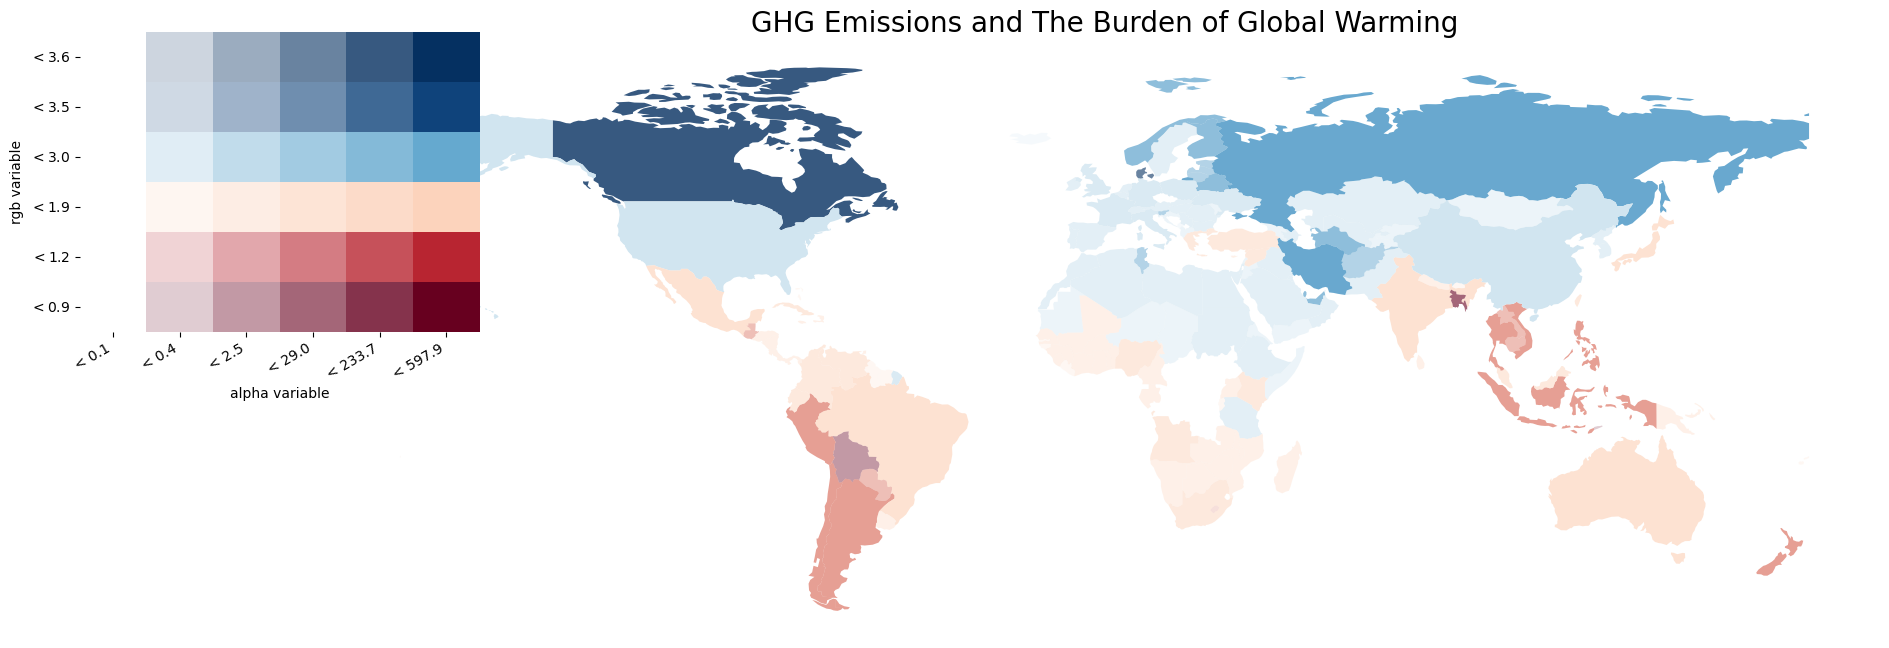

In [16]:
#plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,15))
vba_choropleth(
    wb['Warming_since_1960'].values, 
    wb['Country_Total'].values, 
    wb, 
    rgb_mapclassify=dict(classifier='percentiles'),
    alpha_mapclassify=dict(classifier='percentiles'),
    cmap='RdBu',
    ax=ax,
    revert_alpha=False,
    legend=True)
ax.set_title('GHG Emissions and The Burden of Global Warming', fontdict={'size': 20})
ax.patch.set_facecolor('lightgrey')
plt.show()

#print(plt.style.available)
